# NLP Training 

#### Import dependencies

In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
replace test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C

    Linking successful
    /home/oussama/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
    /home/oussama/anaconda3/lib/python3.7/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Exemple de plan:

Introduction
------------------

- RNN 1, classification du texte 
- RNN 2, marquage de séquence
- RNN 3, génération de texte, modèles de langage


Classification du texte
Commençons par la plus simple - analyse de la tonalité du texte.

Nous allons classer les commentaires de la BDIM en positifs / négatifs.

In [3]:
!head train.tsv

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000



comment déterminer le sentiment?

Le plus simple, est de trouver des mots-clés.


In [5]:
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))



Test accuracy = 66.73%


In [6]:
import re

pattern = re.compile('<smth>')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])


Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 



Obtenons un grand dictionnaire - une liste de tous les mots du jeu d’entraînement.
 Ensuite, chaque phrase peut être représentée sous forme de vecteur dans lequel elle sera écrite,
 combien de fois chacun des mots possibles a été rencontré:
     
Une façon simple et agréable de faire cela consiste à insérer des textes dans CountVectorizer.

Il porte la signature suivante:

Voyons d’abord les paramètres minuscule = True et max_df = 1.0, min_df = 1, max_features = None - ils signifient que par défaut tous les mots seront convertis en minuscules et que tous les mots trouvés dans les textes seront inclus dans le dictionnaire.

il serait possible de supprimer des mots trop rares ou trop fréquents

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)
# Regardons les mots dans le dictionnaire:
vectorizer.get_feature_names()
# Essayons de convertir quelqu'un
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 207 stored elements in Compressed Sparse Row format>


certains mots sont de couleur positive, d'autres - négatifs. La plupart sont généralement neutres, oui.

il faut choisir les coefficients qui détermineront le niveau de couleur

Par exemple, pour l'échantillonnage

1 Le film était excellent
0 le film était affreux
Il est facile de choisir les cotes sur les yeux: quelque chose comme +1 pour excellent, -1 pour affreux et zéros pour tout le monde.

Construisons un modèle linéaire pour le faire. Elle apprendra à construire un hyperplan séparateur dans l'espace des vecteurs d'arc.

 


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40105812  0.40105812  0.          0.          0.        ]]


/home/oussama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
#Il s'est avéré que c'est nécessaire.
#Maintenant, exécutez-le sur des données réelles.

model.fit(train_df['review'], train_df['is_positive'])

from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.67%


In [11]:

import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)


Weight?,Feature
+1.585,refreshing
+1.414,wonderfully
+1.346,erotic
+1.292,funniest
+1.288,excellent
+1.286,perfect
+1.267,superb
+1.262,carrey
+1.253,appreciated
+1.243,surprisingly


In [12]:
# Regardons des exemples spécifiques
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

print('Positive' if test_df['is_positive'].iloc[0] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])


Positive
Negative


In [13]:
# Regardons des exemples de classification incorrecte, enfin:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])


# TF-IDF


nous examinons tous les mots avec le même poids - bien que certains soient plus rares, d’autres plus fréquents, et cette fréquence est utile, d’une manière générale, comme information.

Le moyen le plus simple d’ajouter des informations statistiques sur les fréquences est de procéder à la pesée tf-idf:

$$ \ text {tf-idf} (t, d) = \ text {tf} (t, d) \ times \ text {idf} (t) $$
tf - fréquence-terme - fréquence du mot t dans un document spécifique d (révisions dans notre cas). C'est exactement ce que nous avons déjà pensé.

idf - fréquence de document inverse - le coefficient, qui est le plus grand, le plus petit nombre de documents rencontrés avec ce mot. On considère quelque chose comme ceci: $$ \ text {idf} (t) = \ text {log} \ frac {1 + n_d} {1 + n_ {d (t)}} + 1 $$ où $ n_d $ est un nombre tous les documents, et $ n_ {d (t)} $ est le nombre de documents contenant le mot t.

Son utilisation est simple: vous devez remplacer CountVectorizer par TfidfVectorizer.

Essayez de lancer TfidfVectorizer. Regardez les erreurs qu’il a appris à corriger, et celles qu’il a commencé à commettre - comparées au CountVectorizer.
 


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/home/oussama/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test accuracy = 88.31%



N-grammes de mots
------------------------------
Jusqu'à présent, nous avons considéré les textes comme un sac de mots - mais il est évident qu'il existe une différence entre un bon film et un mauvais film.

Ajoutez des informations (au moins certaines) sur les séquences de mots - nous allons également extraire les digrammes de mots.

Dans Vectorizers, cela a le paramètre ngram_range = (n_1, n_2) - il indique que nous avons besoin de n_1 -... n_2-grammes.


In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.63%



N-grammes de caractères
-----------------------
Les n-grammes de caractères constituent un moyen simple d’apprendre les racines et les suffixes utiles sans être associé à votre linguistique - seulement des statistiques.

Tâche Réduisez le classificateur en n-grammes de caractères et visualisez-le.


In [16]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])


Test accuracy = 87.66%
Positive



Lemmatisation et stemming
Si vous regardez de plus près, vous pouvez trouver les formes d’un mot avec différentes couleurs sémantiques en fonction du classifieur ?

Tâche: Trouver des formes d'un mot avec une couleur sémantique différente.

Croyez qu'ils sont, essayez quelque chose à faire avec cela.

Par exemple, lemmatiser - nous réduirons tous les mots à la forme initiale. La bibliothèque spacy aidera à  faire cela.


In [17]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

for token in docs[0]:
    print(token.text, token.lemma_)

Dreamgirls dreamgirl
, ,
despite despite
its -PRON-
fistful fistful
of of
Tony tony
wins win
in in
an an
incredibly incredibly
weak weak
year year
on on
Broadway broadway
, ,
has have
never never
been be
what what
one one
would would
call call
a a
jewel jewel
in in
the the
crown crown
of of
stage stage
musicals musical
. .
However however
, ,
that that
is be
not not
to to
say say
that that
in in
the the
right right
cinematic cinematic
hands hand
it -PRON-
could could
not not
be be
fleshed flesh
out out
and and
polished polish
into into
something something
worthwhile worthwhile
on on
- -
screen screen
. .
Unfortunately unfortunately
, ,
what what
transfers transfer
to to
the the
screen screen
is be
basically basically
a a
slavishly slavishly
faithful faithful
version version
of of
the the
stage stage
hit hit
with with
all all
of of
its -PRON-
inherent inherent
weaknesses weakness
intact intact
. .
First first
, ,
the the
score score
has have
never never
been be
one one
of of
the the
str


Faites un classificateur sur les textes lemmatisés.

Un moyen plus simple de normaliser les mots est d’utiliser l’option stemming. 

En général, il s’agit simplement d’un ensemble de règles permettant de couper un mot pour obtenir un radical:


In [18]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


# NER

In [19]:
"""
Essayez de classer les bases au lieu des lemmes.

NER
Il y a beaucoup d'entités nommées dans les textes de révision. Ici, par exemple:
"""
displacy.render(docs[0], style='ent', jupyter=True)


De manière générale, pourquoi un Depp devrait-il avoir une coloration sémantique? Cependant, il se trouve que le classificateur apprend que certains noms figurent plus souvent dans des critiques positives, ou inversement. Cela ressemble à du recyclage - pourquoi ne pas essayer de supprimer des entités?

Tâche Supprimez certaines des entités des textes, en utilisant les coordonnées des fichiers bourrés. La description des entités peut être trouvée ici. Exécutez le classificateur.

Estimons par l'histogramme, quelle longueur nous convient:
 



<a list of 219 Patch objects>

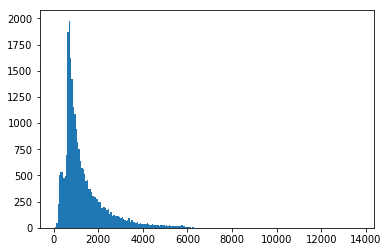

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text)), bins='auto')
hist

In [21]:
# De plus, vous devez renuméroter les mots.
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10000:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 68


In [24]:
# Quest Convert Data
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    #<fill the matrix>
    return data

X_train = convert(train_df.review, word2idx, 10000)
X_test = convert(test_df.review, word2idx, 10000)